## DMS Development Across ADRB2, MC4R, and TYK2

1. [Data Harmonization](#part1)
    -    [ARRB2](#part1a)
    -    [MC4R](#part1b)
    -    [TYK2](#part1c)
2. [Comparisons](#part2)

### Data Harmonization <a name="part1"></a>

In [2]:
library(ggpubr)
library(vroom)
library(stringr)
library(tidyverse)

Loading required package: ggplot2

Registered S3 methods overwritten by 'readr':
  method                    from 
  as.data.frame.spec_tbl_df vroom
  as_tibble.spec_tbl_df     vroom
  format.col_spec           vroom
  print.col_spec            vroom
  print.collector           vroom
  print.date_names          vroom
  print.locale              vroom
  str.col_spec              vroom

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ purrr   0.3.5 
✔ tidyr   1.2.1      ✔ dplyr   1.0.10
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_character()   masks vroom::col_character()
✖ readr::col_date()        masks vroom::col_date()
✖ readr::col_datetime()    masks vroom::col_datetime()
✖ readr::col_double()      masks vroom::col_double()
✖ readr::col_factor()      masks vroom::col_factor()
✖ readr::col_guess()       masks vroom::col_guess()
✖ readr::col_int

#### ARRB2 <a name="part1a"></a>

In [3]:
b2 <- read_tsv("../sumstats/b2.sumstats.tsv") %>%
    separate(term, c("condition","aa"), ":")

b2_control <- b2 %>% 
    filter(condition == "conditionF") %>% 
    select(-condition, -forsk_expr) %>%
    mutate(condition = "control")
b2_expr <- b2 %>% 
    filter(condition == "condition5") %>% 
    select(-condition, -forsk_expr) %>%
    mutate(condition = "treated")

b2 <- bind_rows(b2_control, b2_expr) %>%
    select(-statistic, -p_value) %>%
    group_by(pos, aa) %>%
    pivot_wider(names_from = condition, values_from = c(estimate, std_error)) %>%
    summarize(estimate = estimate_treated - estimate_control,
              std.error = sqrt((std_error_treated^2)+(std_error_control^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos,aa,estimate,std.error,statistic,p.value) %>%
    mutate(aa = if_else(aa == "aaIndel","Stop","Nonstop"),
           group = "ADRB2")

Rows: 46194 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): forsk_expr, term
dbl (5): pos, estimate, std_error, statistic, p_value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'pos'. You can override using the `.groups`
argument.


#### MC4R <a name="part1b"></a>

In [4]:
mc4r_gs <- read_tsv("../sumstats/DMS5-final.sumstats.tsv") %>%
    filter(Drug == "aMSH" & Concentration == 5e-10 & Level %in% c("Forsk","aMSH")) %>%
    select(Pos, Estimate, SE, Level, AA) %>%
    group_by(Pos, AA) %>%
    pivot_wider(names_from = Level, values_from = c(Estimate, SE)) %>%
    summarize(estimate = Estimate_aMSH - Estimate_Forsk,
              std.error = sqrt((SE_aMSH^2)+(SE_Forsk^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos = Pos,aa = AA,estimate,std.error,statistic,p.value) %>%
    mutate(group = "MC4R, Gs") %>%
    mutate(aa = if_else(aa == "Stop","Stop","Nonstop"))

Rows: 119394 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Chunk, Drug, Level, AA, WT_Codon, WT_AA_Short, WT_AA
dbl (10): Pos, Concentration, Estimate, SE, Statistic, P.value, theta, q, lo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Pos'. You can override using the `.groups`
argument.


In [5]:
mc4r_gq <- read_tsv("../sumstats/DMS8-final.sumstats.tsv") %>%
    filter(Drug == "aMSH" & Concentration == 2e-8 & Level %in% c("none","aMSH")) %>%
    select(Pos, Estimate, SE, Level, AA) %>%
    group_by(Pos, AA) %>%
    pivot_wider(names_from = Level, values_from = c(Estimate, SE)) %>%
    summarize(estimate = Estimate_aMSH - Estimate_none,
              std.error = sqrt((SE_aMSH^2)+(SE_none^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    select(pos = Pos,aa = AA,estimate,std.error,statistic,p.value) %>%
    mutate(group = "MC4R, Gq") %>%
    mutate(aa = if_else(aa == "Stop","Stop","Nonstop"))

Rows: 79596 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): Chunk, Drug, Level, AA, WT_Codon, WT_AA_Short, WT_AA
dbl (10): Pos, Concentration, Estimate, SE, Statistic, P.value, theta, q, lo...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'Pos'. You can override using the `.groups`
argument.


#### TYK2 <a name="part1c"></a>

In [6]:
tyk2 <- read_tsv("../sumstats/10-combined.sumstats.tsv") %>%
    mutate(term = gsub("condition|mut_aa","",term)) %>%
    separate(term, c("condition","aa"), sep = ":") %>%
    select(-statistic, -p.value) %>%
    group_by(pos, clone, chunk, aa) %>%
    pivot_wider(names_from = condition, values_from = c(estimate, std.error)) %>%
    summarize(estimate = estimate_IFNa2a - estimate_none,
              std.error = sqrt((std.error_IFNa2a^2)+(std.error_none^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    ungroup() %>%
    mutate(group = paste0("TYK2, clone ",clone)) %>%
    select(pos,aa,estimate,std.error,statistic,p.value, group) %>%
    mutate(aa = if_else(aa == "*","Stop","Nonstop"))

Rows: 5600 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): clone, term
dbl (6): pos, chunk, estimate, std.error, statistic, p.value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'pos', 'clone', 'chunk'. You can override
using the `.groups` argument.


In [7]:
tyk2_clonal <- read_tsv("../sumstats/10-clonal.sumstats.tsv")  %>%
    mutate(term = gsub("condition|mut_aa","",term)) %>%
    separate(term, c("condition","aa"), sep = ":") %>%
    select(-statistic, -p.value) %>%
    group_by(pos, chunk, aa) %>%
    pivot_wider(names_from = condition, values_from = c(estimate, std.error)) %>%
    summarize(estimate = estimate_IFNa2a - estimate_none,
              std.error = sqrt((std.error_IFNa2a^2)+(std.error_none^2)),
              statistic = estimate/std.error,
              p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                             (1-pnorm(statistic, sd = 1))*2)) %>%
    ungroup() %>%
    mutate(group = "TYK2, clones combined") %>%
    select(pos,aa,estimate,std.error,statistic,p.value, group) %>%
    mutate(aa = if_else(aa == "*","Stop","Nonstop"))

Rows: 2800 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): term, version
dbl (6): pos, chunk, estimate, std.error, statistic, p.value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'pos', 'chunk'. You can override using the
`.groups` argument.


### Comparisons <a name="part2"></a>

In [8]:
all_data <- bind_rows(b2, mc4r_gs, mc4r_gq, tyk2, tyk2_clonal)

Warning message:
“Removed 114 rows containing non-finite values (stat_density).”


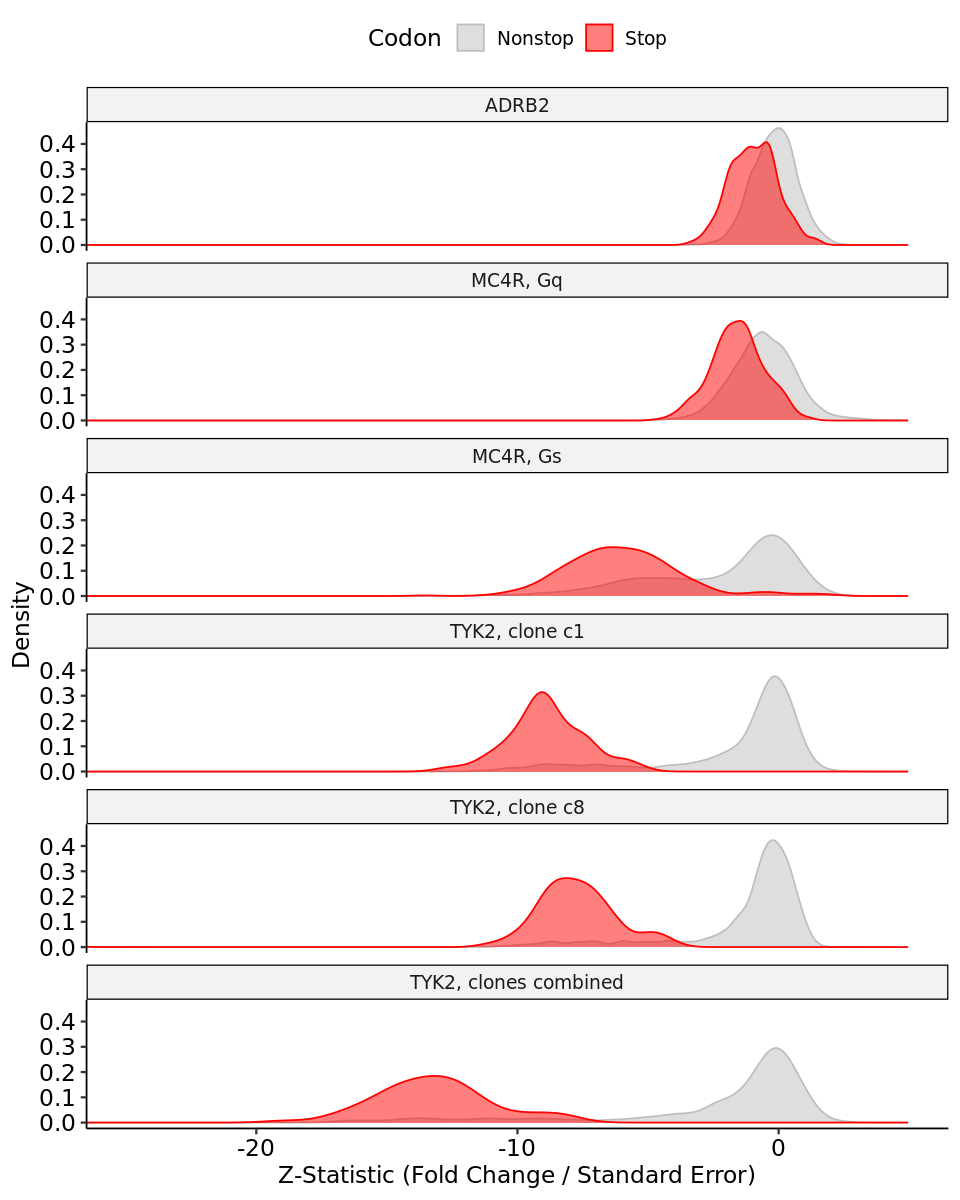

In [9]:
options(repr.plot.height = 10, repr.plot.width = 8)
all_data %>%
    rename("Codon" = "aa") %>%
    ggplot() +
        geom_density(aes(x = statistic, fill = Codon, color = Codon), alpha = 0.5) +
        facet_wrap(~group, ncol = 1) +
        theme_pubr(base_size = 14) +
        scale_fill_manual(values = c("Nonstop" = "gray", "Stop" = "red")) +
        scale_color_manual(values = c("Nonstop" = "gray", "Stop" = "red")) +
        ylab("Density") + xlab("Z-Statistic (Fold Change / Standard Error)") +
        coord_cartesian(xlim = c(-25,5))

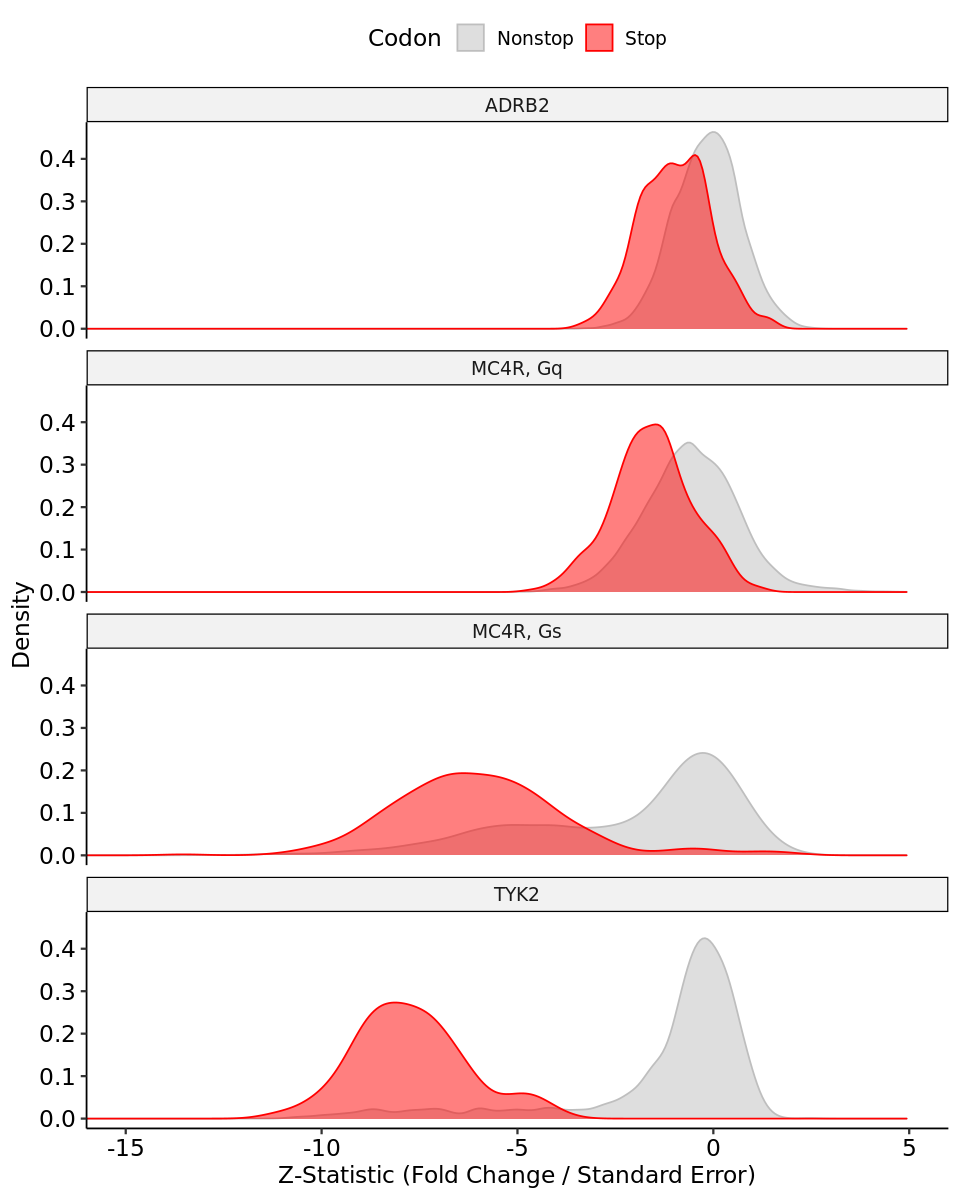

In [10]:
options(repr.plot.height = 10, repr.plot.width = 8)
all_data %>%
    filter(group %in% c("ADRB2","MC4R, Gq", "MC4R, Gs", "TYK2, clone c8"), !is.na(statistic)) %>%
    mutate(group = gsub("TYK2, clone c8","TYK2",group)) %>%
    rename("Codon" = "aa") %>%
    ggplot() +
        geom_density(aes(x = statistic, fill = Codon, color = Codon), alpha = 0.5) +
        facet_wrap(~group, ncol = 1) +
        theme_pubr(base_size = 14) +
        scale_fill_manual(values = c("Nonstop" = "gray", "Stop" = "red")) +
        scale_color_manual(values = c("Nonstop" = "gray", "Stop" = "red")) +
        ylab("Density") + xlab("Z-Statistic (Fold Change / Standard Error)") +
        coord_cartesian(xlim = c(-15,5))